# Benchmarking


In [1]:
import timeit
import numpy as np
from functools import partial

import pyclesperanto as cle
try:
    import cupy as xp
except:
    import numpy as xp
    Warning("Cupy not found, using numpy instead.")
try:
    import cupyx.scipy.ndimage as xdi
except:
    import scipy.ndimage as xdi
    Warning("Cupy not found, using scipy instead.")

import matplotlib.pyplot as plt

from skimage.io import imread

## JIT Compilation and Cache

Run the following cell and compare the speed run of the gaussian filter on your machine. What can you tell?

In [2]:
# Random data for testing
arr = np.random.rand(2,2000,2000).astype(np.float32)
cl_arr = cle.push(arr)
cu_arr = xp.asarray(arr)


In [3]:
from skimage.filters import gaussian

start = timeit.default_timer()
gaussian(arr, sigma=5)
end = timeit.default_timer()
print("skimage took", end - start, "seconds")

start = timeit.default_timer()
xdi.gaussian_filter(cu_arr, sigma=5)
end = timeit.default_timer()
print("cupy took", end - start, "seconds")

start = timeit.default_timer()
cle.gaussian_blur(cl_arr, sigma_x=5, sigma_y=5)
end = timeit.default_timer()
print("clesperanto took", end - start, "seconds")

skimage took 0.21884039900032803 seconds
cupy took 0.027052187972003594 seconds
clesperanto took 0.004499514994677156 seconds


Re-run the cell and comment the different ...


The first run on GPU will usually require a compilation time that is done at runtime. This allows fexibility on the operation to be runned to the cost of speed for the first execution. Both Cupy and clEsperanto will rely on a cache system which store all the kernel build previously to skip this compilation time if possible.

You can see it in a `.cache` hidden folder for POSIX and in the `%APPDATA%` folder on Windows.

## Blocking threads and asynchronisation

In [4]:
from skimage.filters import gaussian

def cpu_function(arr, sigma):
    gaussian(arr, sigma=sigma)

def cle_function(arr, sigma):
    cle.gaussian_blur(arr, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)

def cu_function(arr, sigma):
    xdi.gaussian_filter(arr, sigma)

size = []
cpu_times = []
cupy_times = []
cle_times = []

sigma = 5
warm_up_iter = 1
eval_iter = 3
for i in range(10, 1000, 100):
    arr = np.random.rand(i, i, i).astype(np.float32)
    cl_arr = cle.push(arr)
    cu_arr = xp.asarray(arr)

    size.append(arr.itemsize * arr.size / 1024 / 1024)

    if size[-1] > 500:
        cpu_times.append(np.nan)
    else:
        partial_function = partial(cpu_function, arr, sigma)
        _ = timeit.timeit(partial_function, number=warm_up_iter)
        t = timeit.timeit(partial_function, number=eval_iter)
        cpu_times.append(t)

    partial_function = partial(cu_function, cu_arr, sigma)
    _ = timeit.timeit(partial_function, number=warm_up_iter)
    t = timeit.timeit(partial_function, number=eval_iter)
    cupy_times.append(t)

    partial_function = partial(cle_function, cl_arr, sigma)
    _ = timeit.timeit(partial_function, number=warm_up_iter)
    t = timeit.timeit(partial_function, number=eval_iter)
    cle_times.append(t)

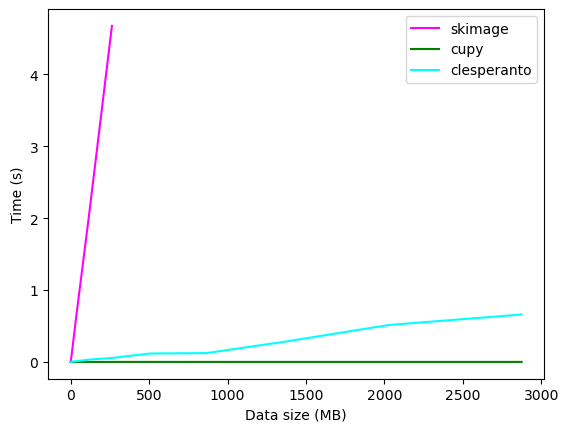

In [5]:
plt.plot(size, cpu_times, label="skimage", color="magenta")
plt.plot(size, cupy_times, label="cupy", color="green")
plt.plot(size, cle_times, label="clesperanto", color="cyan")
plt.xlabel("Data size (MB)")
plt.ylabel("Time (s)")
plt.legend()

A second thing to take in account is the asynchronisation between the CPU and the GPU. When executing a kernel on a device, the CPU does not know when the device is finished or not. Hence, the extreme processing speed of the GPU while in reality we do not know when it actually finished. To enforce this, we need to tell the GPU to finish (synchronise) its command queue. 

### Exercise 1: Fix the benchmarking algorithm to have the correct time

In clesperanto we use the `wait_for_kernel_to_finish` function to trigger this behaviour globally, in Cupy we can call the `cuda.runtime.deviceSynchronize()` after the operation to wait for it.

### Exercise 2: What should be benchmark next?

- Who has the fastest device?
- Who is faster between cupy and clesperanto?